# <font size = 5> Notes</font>

Part 1 of 5: Single atoms

Author: Huan Q. Bui

Affiliation: Fermi1 experiment at Zlabs, MIT
             
PI: Professor Martin Zwierlein

First updated: May 15, 2023

Last updated: August 13, 2023

# <font size = 5>Setting up</font>

In [6]:
# imports
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import os
import scipy
import pandas as pd
from qutip import *
import time
from findiff import FinDiff
from numba import jit
# for diatomic hyperfine + rotational stuff
from sympy.physics.wigner import wigner_3j
from scipy.linalg import block_diag
import scipy.constants
from scipy.special import sph_harm
from matplotlib import pyplot,gridspec,colors,patches,collections
from sympy.physics.wigner import wigner_3j, wigner_6j

In [7]:
# suppress warnings: do at your own risk!
import warnings
warnings.filterwarnings("ignore")

In [8]:
# constants
ABSORPTION_LIMIT = 5.0
SPECIAL_CHARACTERS = "!@#$%^&*()-+?_=,<>/"

# physics constants
hbar = 1.05457182*10**(-34) # Js
c = 299792458 # m/s
h_planck = hbar*2*np.pi  # Js
me = 9.1093837015e-31    # electron mass
mn = 1.67493e-27         # neutron mass
eC = 1.60218e-19         # electric charge
muB = eC*hbar/(2*me)     # Bohr magneton
muB_cm1_G = muB / (100*c*h_planck*1e4) # Bohr magneton in units of cm-1 per Gauss
a0 = 5.2917720859e-11    # Bohr radius
muN = scipy.constants.physical_constants['nuclear magneton'][0]
eps0 = scipy.constants.epsilon_0
gS = 2.0023193043622
DebyeSI = 3.33564e-30

# Lithium constants
mLi6 = 9.9883414*10**(-27) # kg
Li6D2Gamma = 5.8724e6 # Hz Note that this is NOT angular freq
Li6D2lambda0 = 670.977338*10**(-9) # meters
Li6D2sigma0 = 3*(Li6D2lambda0)**2/(2*np.pi)
Li6Ahf_s12 = 152.1368407e6  # This is NOT angular freq
Li6Bhf_s12 = 0
Li6Ahf_p12 = 17.386e6 # Hz
Li6Bhf_p12 = 0
Li6Ahf_p32 = -1.155e6 # Hz
Li6Bhf_p32 = -0.10e6 # Hz
Li6I = 1
Li6gI = -0.0004476540

# Sodium-23 constants
mNa23 = 0.38175403519e-25 # kg
Na23D2Gamma = 9.794646e6 # Hz
Na23D2lambda0 = 589.158326415e-9 # meters
Na23D2sigma0 = 3*(Na23D2lambda0)**2/(2*np.pi)
Na23Ahf_s12 = 885.8130644050e6 # Hz
Na23Bhf_s12 = 0e6 # Hz
Na23Ahf_p12 = 94.4413e6 # Hz
Na23Bhf_p12 = 0e6 # Hz
Na23Ahf_p32 = 18.53415e6 # Hz
Na23Bhf_p32 = 2.72430e6 # Hz
Na23I = 3/2
Na23gI = -0.0008046108080

# Potassium-40 constants
mK40 = 39.9639984821*1.6605402e-27 # kg 
K40D2Gamma = 6.03511 # MHz
K40D2lambda0 = 766.700674872173e-9 # meters
K40D2sigma0 = 3*(K40D2lambda0)**2/(2*np.pi)
K40Ahf_s12 = -285.730824e6 # Hz
K40Bhf_s12 = 0
K40Ahf_p12 = -34.52325e6 # Hz
K40Bhf_p12 = 0
K40Ahf_p32 = -7.58510e6 # Hz
K40Bhf_p32 = -3.44590e6 # Hz
K40I = 4
K40gI = 0.00017649034

# NaK constants:
mK41 = 6.80187059497004e-26 # kg
mK40 = 6.63617749148248e-26 # kg
mK39 = 6.47007514485677e-26 # kg
u = 1.660538782e-27  # kg
Eh = 4.35974394e-18 
RKRcst = hbar/np.sqrt(2*u) * (10**10) * np.sqrt(1/(100 * c * hbar * 2*np.pi)) 
muNa39K = (mNa23 * mK39)/(mNa23 + mK39) * 1/u # atomic units
muNa40K = (mNa23 * mK40)/(mNa23 + mK40) * 1/u # atomic units 
muNa41K = (mNa23 * mK41)/(mNa23 + mK41) * 1/u # atomic units

# <font size = 5>Zeeman Effect Calculator</font>

In [1]:
# helper functions
def A_hfs(J, I, mj, mi, mjj, mii):
    Ahfs = 0
    if (mj == mjj) and (mi == mii):
        Ahfs = mj*mi
    elif (mj == mjj + 1.0) and (mi == mii - 1.0):
        Ahfs = (1/2)*np.sqrt((J+mj)*(J-mj+1)*(I-mi)*(I+mi+1))
    elif (mj == mjj - 1.0) and (mi == mii + 1.0): 
        Ahfs = (1/2)*np.sqrt((J-mj)*(J+mj+1)*(I+mi)*(I-mi+1))
    else:
        Ahfs = 0
    return Ahfs

def B_hfs(J, I, mj, mi, mjj, mii):
    # reference: N. Ramsey's Molecular Beams... some Appendix, I believe
    Bhfs = 0
    if (mj == mjj) and (mi == mii):
        Bhfs = (1/2)*(3*mi**2-I*(I+1))*(3*mj**2-J*(J+1))
    elif (mjj == mj - 1) and (mii == mi + 1):   
        Bhfs = (3/4)*(2*mjj-1)*(2*mii+1)*np.sqrt((J+mjj)*(J-mjj+1)*(I-mii)*(I+mii+1))
    elif mjj == mj + 1 and mii == mi - 1:
        Bhfs = (3/4)*(2*mjj+1)*(2*mii-1)*np.sqrt((J-mjj)*(J+mjj+1)*(I+mii)*(I-mii+1))
    elif mjj == mj - 2 and mii == mi + 2 :  
        Bhfs = (3/4)*np.sqrt((J+mjj)*(J+mjj-1)*(J-mjj+1)*(J-mjj+2)*(I-mii)*(I-mii-1)*(I+mii+1)*(I+mii+2))
    elif mjj == mj + 2 and mii == mi - 2:
        Bhfs = (3/4)*np.sqrt((J-mjj)*(J-mjj-1)*(J+mjj+1)*(J+mjj+2)*(I+mii)*(I+mii-1)*(I-mii+1)*(I-mii+2))
    else:
        Bhfs = 0

    if (2*I*(2*I-1)*J*(2*J-1)) != 0:
        Bhfs = Bhfs/(2*I*(2*I-1)*J*(2*J-1))
    return Bhfs

def mag(B, J, L, S, mj, mi, mjj, mii, gI):
    gL = 1 - me/mn           # gyro magnetic factor of the orbital
    gS = 2.0023193043622     # electron spin g-factor
    gJ = gL*(J*(J+1)-S*(S+1)+L*(L+1))/(2*J*(J+1)) + gS*(J*(J+1)+S*(S+1)-L*(L+1))/(2*J*(J+1)) # verified, correct :)
    
    mag = 0
    if mj == mjj and mi == mii:
        mag = (muB/hbar)*(gJ*mj + gI*mi)*B*1e-4 # B is in Gauss, need to convert to Tesla
    else:
        mag = 0

    return mag/(2*np.pi) # return answer in Hz

In [2]:
# zeeman splitting calculator
def zeeman_splitting_calculator(J, I, gI, L, S, B_main, B_start, B_end, num_B, Ahf, Bhf = 0, 
                                plotting = True, highlight_HF_states = [0,0], plot_range = None, 
                                single_B_field_calc_mode = False, print_field_sensitivity_between = None,
                                search_mode = False, splitting = 0, splitting_between_states = None, labeling_mode='lf'):

    B_start = min(B_start, B_end)
    B_end = max(B_start, B_end)
    if num_B >= 20:
        B_fields = np.linspace(B_start, B_end, num_B)
        if B_main < max(B_fields) and B_main > min(B_fields):
            B_fields = np.append(B_fields, B_main)
            B_fields = np.sort(B_fields)
        else:
            print('The variable "B_main" is not in B fields!')
            return 0        
    else:
        print('Number of points must exceed 20!')
        return 0
    
    # possible Js
    possible_Js = np.arange(abs(L-S), abs(L+S)+1, 1)
    if J > max(possible_Js) or J < min(possible_Js):
        print('Invalid J!')
        return 0
    mJ = np.linspace(-J, J, int(2*J+1))
    mI = np.linspace(-I, I, int(2*I+1))
   
    # now make a basis:
    basis = [] # which is the set {[mj, mi]}
    for mj in mJ:
        for mi in mI:
            basis.append([mj, mi])
            mF = mj + mi
    size = len(basis)
    H = np.empty((size,size))
    list_of_freqs = [ ]

    # generate the zeeman Hamiltonian and diagonalize it 
    for b in B_fields:
        for r in range(size):
            mj = basis[r][0]
            mi = basis[r][1]
            for c in range(size):
                mjj = basis[c][0]
                mii = basis[c][1]
                H[r,c] = Ahf * A_hfs(J, I, mj, mi, mjj, mii) + Bhf * B_hfs(J, I, mj, mi, mjj, mii) + mag(b, J, L, S, mj, mi, mjj, mii, gI)
        freqs, eigenvectors = np.linalg.eigh(H) 
        freqs = freqs * 1e-6
        list_of_freqs.append(freqs)

    # Plotting, labeling states, and returning statistics:
    list_of_freqs = np.array(list_of_freqs)
    list_of_freqs = np.sort(list_of_freqs, axis=1)    
    highlight_HF_states = np.array(highlight_HF_states)
    if plotting:
        for s in range(size):
            plt.plot(B_fields, list_of_freqs[:,s], linewidth = 0.5, color='red')
        if highlight_HF_states.all() in np.arange(1, size+1,1):
            for state in highlight_HF_states:
                plt.plot(B_fields[np.where((B_fields == B_main))[0][0]:], 
                         list_of_freqs[np.where((B_fields == B_main))[0][0] : , state-1], linewidth = 1.5 , color = 'black')
        if plot_range is not None:
            plt.ylim(plot_range)
        plt.xlabel('Magnetic field (G)')
        plt.ylabel('Energy shift (MHz)')
        # labeling states depending on high or low field:
        gL = 1 - me/mn           # gyro magnetic factor of the orbital
        gS = 2.0023193043622     # electron spin g-factor
        gJ = gL*(J*(J+1)-S*(S+1)+L*(L+1))/(2*J*(J+1)) + gS*(J*(J+1)+S*(S+1)-L*(L+1))/(2*J*(J+1)) # verified, correct :)
        if labeling_mode=='lf':
            # print out (F,mF) basis
            basisF = []
            possible_Fs = np.arange(abs(I-J), abs(I+J)+1, 1)
            if gI > 0:
                possible_Fs = np.flip(possible_Fs)
            for F in possible_Fs:
                gF = gJ*(F*(F+1) - I*(I+1) + J*(J+1))/(2*F*(F+1)) # without dividing a positive
                if gF > 0:
                    # if positive, then mF negative to positive:
                    mF = np.linspace(-F, F, int(2*F+1))
                    for mf in mF:
                        basisF.append([F,mf])
                else:
                    # if negative, then mF positive to negative:
                    mF = np.flip(np.linspace(-F, F, int(2*F+1)))
                    for mf in mF:
                        basisF.append([F,mf])
            basisF = np.array(basisF)
            print('(F, mF) basis, low to high in energy: ')
            print(basisF)
        elif labeling_mode=='hf':
            # rank the mj mi basis based on the value of gJ * mJ + gI*mI:
            vals = []
            for b in basis:
                B_hf = 10*Ahf*hbar*2*np.pi/(muB *1e-4)
                vals.append(  Ahf*b[0]*b[1] + (gJ*b[0] + gI*b[1])*B_hf*1e-4*muB/(hbar*2*np.pi)    )
            sort_vals = np.argsort(np.array(vals))
            sorted_mJmI_basis = np.array(basis)
            sorted_mJmI_basis = sorted_mJmI_basis[sort_vals]
            print('(mJ, mI) basis, low to high in energy: ')
            print(sorted_mJmI_basis)
        elif labeling_mode == 'none':
            print('No state labeling')
        plt.grid()
        plt.show()   

    # Compute relevant statistics:
    if single_B_field_calc_mode:
        freqs = list_of_freqs[np.where(B_fields == B_main)[0][0]]
        print('Frequencies (MHz)')
        print(freqs)
        print('Frequency spacings (MHz), from low to high in state energy, at ' + str(B_main) +  ' G:')
        for i in range(len(freqs)-1):
            print("{:.4f}".format(freqs[i+1] - freqs[i]))    
        print(' ')    
        # Field sensitivities:
        print('Field sensitivity of shift (MHz per G), from low to high in state energy, at ' + str(B_main) + ' G:')
        freqs_next = list_of_freqs[np.where(B_fields == B_main)[0][0] + 1]
        freqs_diff = freqs_next - freqs
        Bs_diff = B_fields[np.where(B_fields == B_main)[0][0] + 1] - B_fields[np.where(B_fields == B_main)[0][0]]
        for i in range(len(freqs)):
            print("{:.3f}".format(freqs_diff[i] / Bs_diff))  
        print(' ')

        # Next, calculate the difference between in energy between the two states:
        if print_field_sensitivity_between is not None:
            lower_state  = list_of_freqs[ : , print_field_sensitivity_between[0]-1]
            higher_state = list_of_freqs[ : , print_field_sensitivity_between[1]-1]
            differential_shift =  higher_state - lower_state
            # take derivative:
            dfdB = np.diff(differential_shift)/np.diff(B_fields)
            print( 'Field sensitivity of splitting, df'+str(print_field_sensitivity_between[1])+str(print_field_sensitivity_between[0])+' by dB:')   
            print("{:.4f}".format(dfdB[np.where((B_fields == B_main))[0][0]]) + ' MHz per G')

    # Search for B_field that matches splitting:
    if search_mode:
        if splitting_between_states is not None:
            state_A_freqs = list_of_freqs[ : , splitting_between_states[0]-1]
            state_B_freqs = list_of_freqs[ : , splitting_between_states[1]-1]
            AB_freq_differences = np.abs(state_B_freqs - state_A_freqs - splitting) # assuming no weird crossings...
            AB_freq_diff_min_index = np.argmin(AB_freq_differences)

            print(' ')
            print('Closest B field (G): ' + "{:.2f}".format(B_fields[AB_freq_diff_min_index]))
            splitting_error = state_B_freqs[AB_freq_diff_min_index] - state_A_freqs[AB_freq_diff_min_index] - splitting
            print('Splitting Error (MHz): ' + "{:.5f}".format(splitting_error ))
            if np.abs(splitting_error/splitting) >= 0.1: # if error is too big
                print('Note: large error might be due to bad guesses!')
    return 

(F, mF) basis, low to high in energy: 
[[ 4.5 -4.5]
 [ 4.5 -3.5]
 [ 4.5 -2.5]
 [ 4.5 -1.5]
 [ 4.5 -0.5]
 [ 4.5  0.5]
 [ 4.5  1.5]
 [ 4.5  2.5]
 [ 4.5  3.5]
 [ 4.5  4.5]
 [ 3.5  3.5]
 [ 3.5  2.5]
 [ 3.5  1.5]
 [ 3.5  0.5]
 [ 3.5 -0.5]
 [ 3.5 -1.5]
 [ 3.5 -2.5]
 [ 3.5 -3.5]]


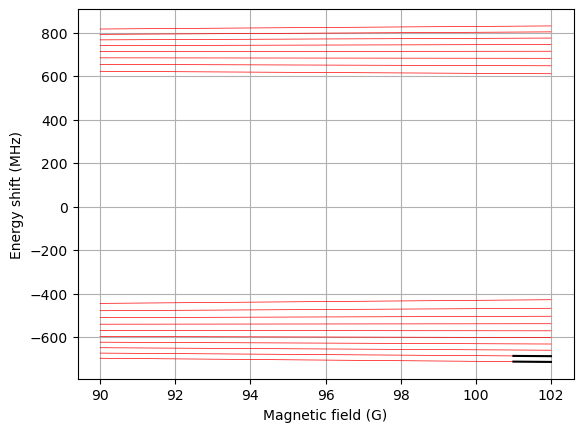

Frequencies (MHz)
[-713.08774639 -686.85072016 -659.67444655 -631.45008297 -602.04598525
 -571.30040093 -539.01084465 -504.91810419 -468.6811337  -429.83554961
  611.72118935  647.90826165  681.95110393  714.19076202  744.88644816
  774.24064769  802.41511309  829.54148851]
Frequency spacings (MHz), from low to high in state energy, at 101.0 G:
26.2370
27.1763
28.2244
29.4041
30.7456
32.2896
34.0927
36.2370
38.8456
1041.5567
36.1871
34.0428
32.2397
30.6957
29.3542
28.1745
27.1264
 
Field sensitivity of shift (MHz per G), from low to high in state energy, at 101.0 G:
-1.402
-1.186
-0.956
-0.710
-0.443
-0.153
0.167
0.525
0.931
1.402
-0.929
-0.524
-0.167
0.153
0.443
0.709
0.955
1.185
 
Field sensitivity of splitting, df21 by dB:
0.2158 MHz per G
 
Closest B field (G): 100.97
Splitting Error (MHz): 0.00011


In [36]:
# Zeeman calculator cell
B_start = 90
B_end = 102
B_main = 101.0 # G
num_B = 5000

# Careful what you type in here!
Ahf = K40Ahf_s12
Bhf = K40Bhf_s12
L = 0
S = 1/2
J = 1/2
I = K40I
gI = K40gI

zeeman_splitting_calculator(J, I, gI, L, S, B_main, B_start, B_end, num_B, Ahf, Bhf, 
                            plotting = True, highlight_HF_states = [1,2], plot_range = None, 
                            single_B_field_calc_mode = True, print_field_sensitivity_between = [1,2],
                            search_mode = True, splitting = 26.2310, splitting_between_states = [1,2],
                            labeling_mode='lf')

# <font size = 5>Landau-Zener transition (linear sweep)</font>

In [9]:
# LZ solver
def LZ_solve(delta0, omegaR, ddelta_dt, psi0, tlist):

    # Hamiltonian
    sx = sigmax()
    sz = sigmaz()
    a = destroy(2)

    H0 = - (delta0/2.0) * sz - (omegaR/2.0) * sx
    H1 = - ddelta_dt/2.0 * sz        

    # collapse operators
    c_op_list = []

    # evolve and calculate expectation values. Method: Cython string-based
    # want to return expectation value of aTa = [[0,0],[0,1]] = P_excited
    H = [H0, [H1, 't']]
    output = mesolve(H, psi0, tlist, c_op_list, [a.dag() * a], {})  

    return output.expect[0]

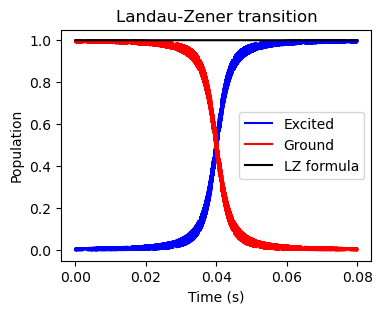

In [26]:
# calculate
sweep_time   = 80e-3              # sweep time in secs
sweep_span   = 800e3 * 2 * np.pi   # sweep span in Hz * 2pi, make sure this is >> omegaR for good LZ
sweep_center = 0 * 2 * np.pi # sweep center in Hz * 2pi
ddelta_dt    = sweep_span/sweep_time   # sweep rate in Hz/s * 2pi
delta0       = -sweep_span/2   # initial detuning in Hz * 2pi
omegaR       = 40e3 * 2 * np.pi   # Rabi frequency in Hz * 2pi
psi0         = basis(2,0)      # initial state
tlist        = np.linspace(0, sweep_time, 10000)
p_ex         = LZ_solve(delta0, omegaR, ddelta_dt, psi0, tlist)

# display results
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(tlist, np.real(p_ex), 'b', tlist, np.real(1-p_ex), 'r')
ax.plot(tlist, 1 - np.exp(-np.pi * omegaR **2 / (2 * ddelta_dt)) * np.ones(np.shape(tlist)), 'k')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Population')
ax.set_title('Landau-Zener transition')
ax.legend(("Excited", "Ground", "LZ formula"), loc=0)
plt.show()

# <font size = 5>Rabi Solution for Two-Level System</font>

In [27]:
def _P2_Rabi(omega, tau, omegaR, omega0, offset):    
    OmegaR = np.sqrt( omegaR**2 + (omega - omega0)**2 )
    return ( omegaR**2 / OmegaR**2) * np.sin( 2*np.pi*OmegaR * tau / 2)**2 + offset

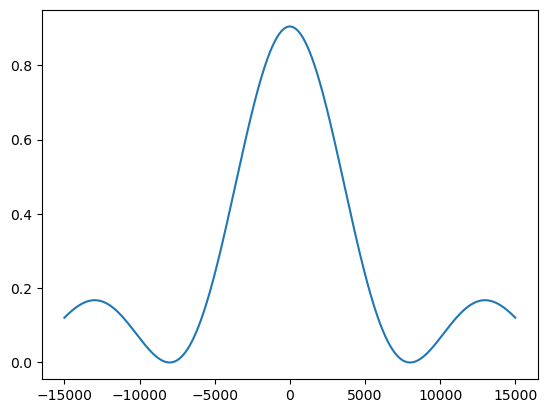

In [34]:
detunings = np.arange(-15e3,15e3,0.001e3)
omega0 = 26.2370e6
tau = 100e-6
omegaR = 6e3
offset = 0
P2 = _P2_Rabi(detunings+omega0, tau , omegaR, omega0, offset)
plt.plot(detunings, P2)
plt.show()

# <font size = 5>Miscellaneous lab calculations</font>

In [43]:
np.concatenate((np.linspace(-20,50,11), np.linspace(50,100,21)))

array([-20. , -13. ,  -6. ,   1. ,   8. ,  15. ,  22. ,  29. ,  36. ,
        43. ,  50. ,  50. ,  52.5,  55. ,  57.5,  60. ,  62.5,  65. ,
        67.5,  70. ,  72.5,  75. ,  77.5,  80. ,  82.5,  85. ,  87.5,
        90. ,  92.5,  95. ,  97.5, 100. ])